# Activity 6 (IC2)

**Professor: Ricardo Prudêncio**

Task:

(PT-BR)
1. Leia sobre LIME no livro dop Molnar (pags. 168 a 173).

2. Crie um modelo para um problema de classificação do seu interesse. Escolha uma instância de cada classe do seu problema e use o LIME para gerar explicações do seu modelo.

(EN)
1. Read about LIME in Molnar's book (pages 168 to 173).

2. Create a model for a classification problem of your interest. Choose an instance from each class of your problem and use LIME to generate explanations for your model.

## Resolution

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from lime import lime_tabular
import matplotlib.pyplot as plt

In [7]:
# Load the heart disease dataset
data = pd.read_csv('heart-disease.csv')

In [8]:
display(data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
# Separate features and target
X = data.drop('target', axis=1)
y = data['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

As the chapter suggests (along with the current LIME documentation), we follow the steps for LIME:
- We take the scaled training data as input.
- We provide the feature names (column names from our dataset) for more interpretable results.
- We specify class names for our binary classification problem.
- We set the mode to 'classification' since we're dealing with a classification task.

In [ ]:
# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    mode='classification'
)

In [ ]:
# Choose an instance from each class to explain
instance_no_disease = X_test_scaled[y_test == 0][0]
instance_disease = X_test_scaled[y_test == 1][0]

In [ ]:
# Function to generate and print explanation
def explain_instance(instance, instance_type):
    exp = explainer.explain_instance(instance, rf_model.predict_proba, num_features=5)
    print(f"\nExplanation for {instance_type} instance:")
    for feature, importance in exp.as_list():
        print(f"{feature}: {importance}")
    
    # Visualize the explanation
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for {instance_type} Instance")
    plt.tight_layout()
    plt.show()

Here's what happens when we explain the instances through LIME:
- It generates a set of perturbed samples around our instance of interest. These are created by slightly varying the feature values.
- It gets predictions from our black-box model (the random forest) for these perturbed samples.
- It then trains a simple, interpretable model on these perturbed samples, weighted by their proximity to the original instance.
- The coefficients of this linear model serve as the explanation, showing how changes in each feature affect the prediction locally.


Explanation for No Heart Disease instance:
slope <= -0.69: -0.13967088186195165
thal <= -0.51: 0.12428747498194799
0.11 < age <= 0.71: -0.10032527679730167
thalach <= -0.63: -0.091957769258568
-0.92 < oldpeak <= -0.19: 0.05778592047677671


<Figure size 1000x600 with 0 Axes>

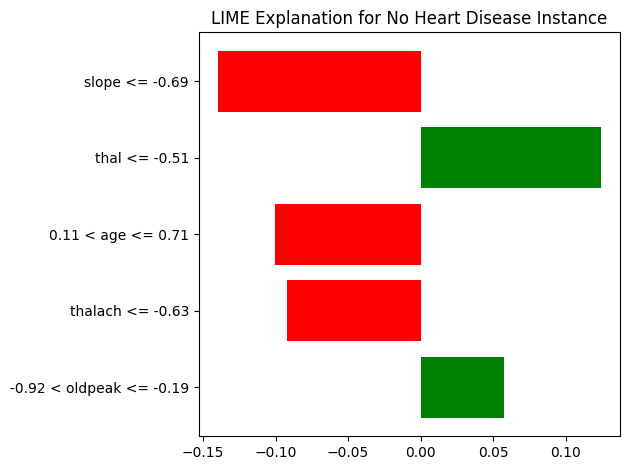


Explanation for Heart Disease instance:
-0.69 < slope <= 0.95: 0.13694205319562933
-0.51 < thal <= 1.18: -0.1301758917478122
0.11 < age <= 0.71: -0.09276938532911914
thalach > 0.70: 0.05873002959535539
exang <= -0.68: 0.053801083585674994


<Figure size 1000x600 with 0 Axes>

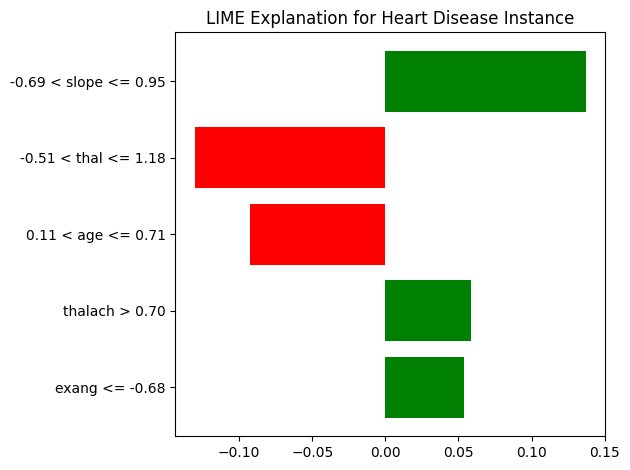


Model Accuracy: 0.84


In [4]:
# Generate explanations for both instances
explain_instance(instance_no_disease, "No Heart Disease")
explain_instance(instance_disease, "Heart Disease")

# Print model accuracy
print(f"\nModel Accuracy: {rf_model.score(X_test_scaled, y_test):.2f}")

We have the following outcome for the "No Heart Disease" instance: The model predicts no heart disease for this instance, primarily due to the strong positive influences of the 'thal' and 'oldpeak' features, which outweigh the negative influences of 'slope', 'age', and 'thalach'.

In depth process:

- Generation of perturbed samples:
When we say LIME generates perturbed samples around our instance of interest, it means LIME creates new data points by slightly modifying the feature values of the original instance. These modifications are not based on the predictions or weightings yet - they're created to explore the local space around the instance.
- Predictions on perturbed samples:
LIME then uses the trained black-box model to make predictions on these perturbed samples. This step helps LIME understand how the model's output changes as the input features vary slightly around the instance of interest.
- Weighting of samples:
After getting the predictions, LIME assigns weights to these perturbed samples based on their proximity to the original instance. Samples that are closer to the original instance get higher weights. This weighting is done using a kernel function (often an exponential kernel).
- Training the local model:
LIME then trains a simple, interpretable model (like a linear regression) on these perturbed samples, using the weights. This local model aims to approximate the behavior of the black-box model in the vicinity of the instance of interest.